In [1]:
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import multivariate_normal as smn
#from jax.scipy.stats import multivariate_normal as jmn
#from jax import random
import scipy

import jax.numpy as jnp

In [2]:
def f(t,t0,sig,P,k):
    return k*jnp.exp(-(t-t0)**2/(2*sig**2))*jnp.sin(2*jnp.pi*t/P)

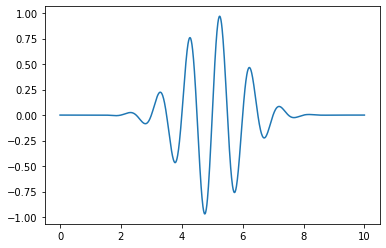

In [3]:
t=jnp.linspace(0,10.0,1000)
plt.plot(t,f(t,5.0,1.0,1.0,1.0))

In [7]:
def RBF(t,tau):
    Dt = t - np.array([t]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    return K

def Matern32(t,tau):
    Dt = t - np.array([t]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [8]:
np.random.seed(seed=1)
N = 512
t = np.linspace(0,30,N)
ave = np.zeros(N)
tau = 3.0
a=5.0
t0_in=15.0
sig_in=1.0
P_in=1.0
k_in=30.0
ave = f(t,t0_in,sig_in,P_in,k_in)
cov = a*RBF(t,tau) #cov = Matern32(t,tau)
di = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
sigma=1.5
d=di+np.random.normal(0.0,sigma,len(di))

Text(0.5, 0, 't')

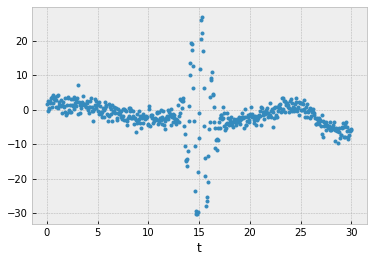

In [9]:
import seaborn as sns
plt.style.use('bmh')
plt.plot(t,d,".")
plt.xlabel("t")

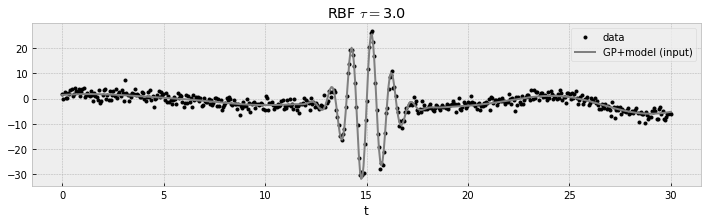

In [129]:

fig=plt.figure(figsize=(12,3 ))
ax=fig.add_subplot(111)

#cov@Pid@d
plt.plot(t,d,".",color="black",label="data")
plt.plot(t,di,color="gray",label="GP+model (input)")
plt.xlabel("t")
plt.title("RBF $\\tau=$"+str(tau))
plt.legend()
plt.savefig("gp1.pdf")

In [130]:
def modelcov(t,tau,a,sigma):
    Dt = t - jnp.array([t]).T
    K=a*jnp.exp(-(Dt)**2/2/(tau**2))+jnp.exp(jnp.eye(N)*sigma**2)
    return K

In [131]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(t,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    tau = numpyro.sample('tau', dist.Uniform(1.0,10.0))
    a = numpyro.sample('a', dist.Exponential(1.))
    cov = modelcov(t,tau,a,sigma)
    
    t0=numpyro.sample("t0",dist.Uniform(14.5,15.5))
    s=numpyro.sample('s', dist.Exponential(1.))
    P=numpyro.sample('P', dist.Uniform(0.9,1.1))
    k=numpyro.sample('k', dist.Exponential(0.1))
    ave = f(t,t0,s,P,k)
    numpyro.sample('y', dist.MultivariateNormal(loc=ave, covariance_matrix=cov), obs=y)

In [110]:
from numpyro.infer import MCMC, NUTS
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples =num_samples)
mcmc.run(rng_key_, t=t, y=d)
mcmc.print_summary()

sample: 100%|█████████████████████████████| 3000/3000 [01:01<00:00, 48.61it/s, 7 steps of size 5.24e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         P      1.00      0.00      1.00      1.00      1.00   3197.03      1.00
         a      4.16      1.33      3.95      2.19      6.19   2699.75      1.00
         k     30.58      0.48     30.56     29.82     31.40   1846.09      1.00
         s      0.96      0.02      0.96      0.94      0.99   1844.54      1.00
     sigma      1.08      0.02      1.08      1.04      1.11   2540.52      1.00
        t0     15.02      0.02     15.02     14.99     15.05   2925.43      1.00
       tau      2.64      0.30      2.64      2.11      3.09   2462.71      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

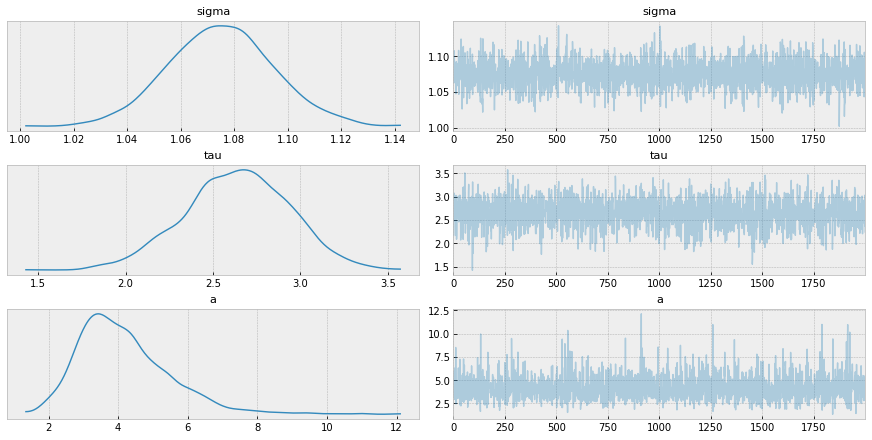

In [111]:
import arviz
arviz.plot_trace(mcmc, var_names=["sigma","tau","a"])
#plt.savefig("gp1.pdf")

In [67]:
tau

3.0

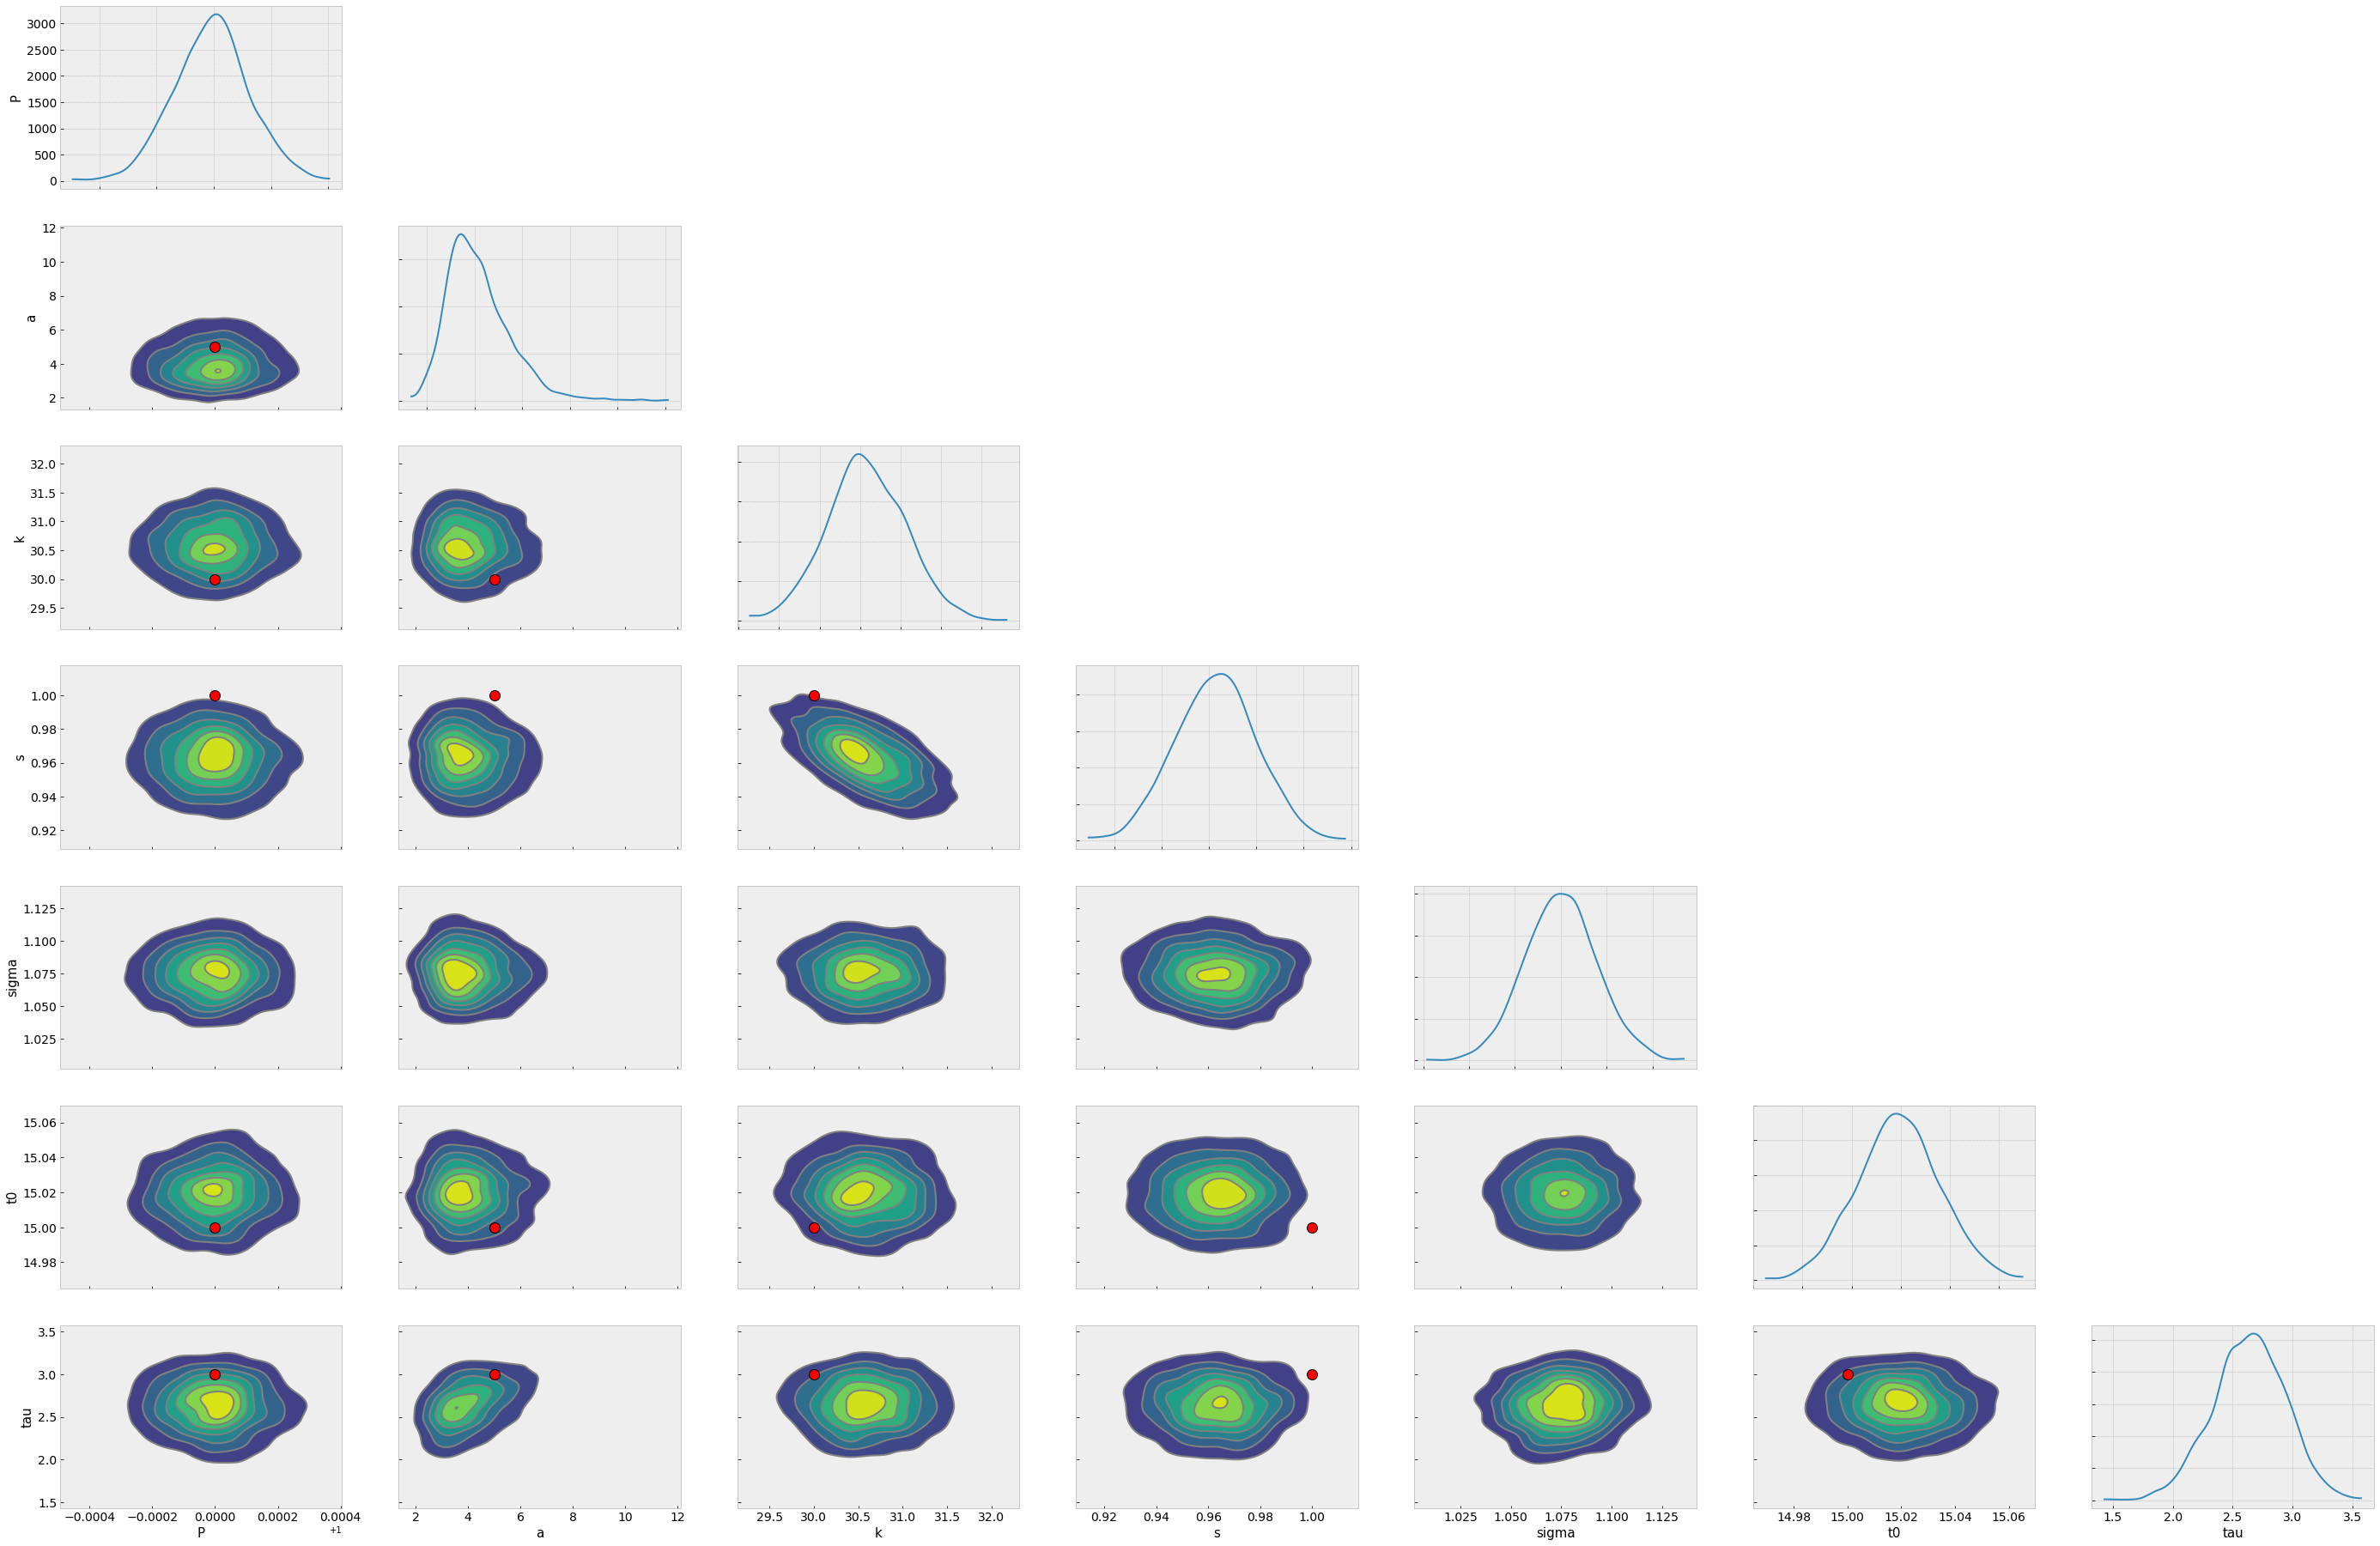

In [112]:
refs={};refs["sigma"]=sigma;refs["tau"]=tau;refs["a"]=a;refs["t0"]=t0_in;refs["s"]=sig_in;refs["k"]=k_in;refs["P"]=P_in;


arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("gp2.pdf", bbox_inches="tight", pad_inches=0.0)

In [113]:
posterior_a = mcmc.get_samples()['a']
posterior_tau = mcmc.get_samples()['tau']
posterior_sigma = mcmc.get_samples()['sigma']
posterior_t0 = mcmc.get_samples()['t0']
posterior_s = mcmc.get_samples()['s']
posterior_P = mcmc.get_samples()['P']
posterior_k = mcmc.get_samples()['k']

In [114]:
np.mean(posterior_tau)

DeviceArray(2.635051, dtype=float32)

In [115]:
from numpyro.infer import Predictive


pred = Predictive(model,{'a':posterior_a,'tau':posterior_tau,'sigma':posterior_sigma,\
                        't0':posterior_t0,'s':posterior_s,'P':posterior_P,'k':posterior_k},return_sites=["y"])
predictions = pred(rng_key_,t=t,y=None)

In [116]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

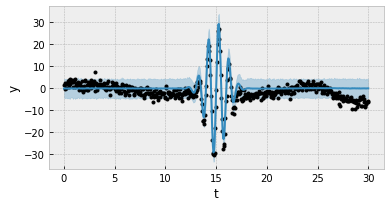

In [117]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(t,d,".",color="black")
ax.plot(t,mean_muy,color="C0")
ax.fill_between(t, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("gp3.pdf")

In [118]:
def muGP(tau,a,sigma):
    cov = a*RBF(t,tau)
    IKw=sigma**2*np.eye(N)+cov
    A=scipy.linalg.solve(IKw,d,assume_a="pos")
    return cov@A

In [119]:
def covGP(tau,a,sigma):
    cov = a*RBF(t,tau)
    IKw=np.eye(N)+cov/sigma**2
    IKw=scipy.linalg.inv(IKw)
    return cov@IKw

In [120]:
import tqdm
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marr=[]
for i in tqdm.tqdm(range(0,10)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    ave=muGP(taus,a_s,sigmas)
    cov=covGP(taus,a_s,sigmas)
#    mn=dist.MultivariateNormal(loc=ave, covariance_matrix=cov)
#    mk = numpyro.sample('a',mn,rng_key=random.PRNGKey(20))
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marr.append(mk)
marr=np.array(marr)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.93it/s]


In [121]:
mean_muy = np.mean(marr, axis=0)
hpdi_muy = hpdi(marr, 0.9)

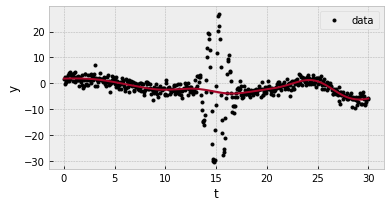

In [122]:
fig=plt.figure(figsize=(6,3 ))
ax=fig.add_subplot(111)
ax.plot(t,d,".",color="black",label="data")
ax.plot(t, mean_muy,color="C1")
ax.fill_between(t, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp4.pdf")

In [123]:
def RBFx(t,td,tau):
    Dt = t - np.array([td]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

def Matern32x(t,td,tau):
    Dt = t - np.array([td]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [124]:
def mucovGPx(t,td,tau,a,sigma,t0,sig,P,k):
    cov = a*RBF(t,tau) + sigma**2*np.eye(N)
    covx= a*RBFx(t,td,tau)
    covxx = a*RBF(td,tau) # + sigma**2*np.eye(N)
    IKw=cov 
    A=scipy.linalg.solve(IKw,d-f(t,t0,sig,P,k),assume_a="pos")
    IKw = scipy.linalg.inv(IKw)
    return f(td,t0,sig,P,k)+covx@A,covxx - covx@IKw@covx.T

In [164]:
import tqdm
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marr=[]
Nd=513
td=np.linspace(-3,33,Nd)
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    t0_s=float(posterior_t0[i])
    s_s=float(posterior_s[i])
    P_s=float(posterior_P[i])
    k_s=float(posterior_k[i])
    ave,cov=mucovGPx(t,td,tau,a_s,sigma,t0_s,s_s,P_s,k_s)
    
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marr.append(mk)
marr=np.array(marr)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:03<00:00,  4.13it/s]


In [165]:
mean_muy = np.mean(marr, axis=0)
hpdi_muy = hpdi(marr, 0.9)

In [166]:
 list(map(int,np.random.random(10)*len(td)))

[351, 390, 459, 242, 27, 288, 326, 197, 337, 38]

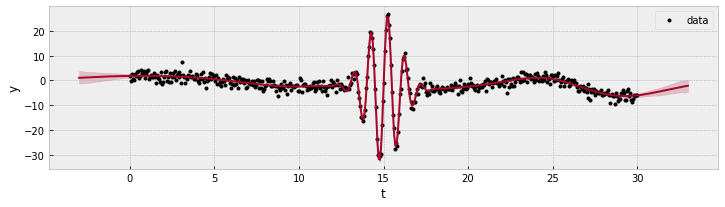

In [167]:
fig=plt.figure(figsize=(12,3 ))
ax=fig.add_subplot(111)
ax.plot(t,d,".",color="black",label="data")
#mu,cov=mucovGPx(t,t,tau,sigma)
#ax.plot(t,mu)
ax.plot(td, mean_muy,color="C1")
ax.fill_between(td, hpdi_muy[0], hpdi_muy[1], alpha=0.2, interpolate=True,color="C1")
#for i in list(map(int,np.random.random(20)*len(td))):
#    plt.plot(td,marr[i,:],lw=0.5,alpha=0.3,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp5.pdf")

In [168]:
from jax import jit
#@jit
def mucovGPxs(t,td,tau,a,sigma,t0,sig,P,k):
    cov = a*RBF(t,tau) + sigma**2*np.eye(N)
    covx= a*RBFx(t,td,tau)
    covxx = a*RBF(td,tau) + sigma**2*np.eye(Nd)
    IKw=cov 
    A=jnp.linalg.solve(IKw,d-f(t,t0,sig,P,k))#,assume_a="pos")
    IKw = jnp.linalg.inv(IKw)
    return f(td,t0,sig,P,k)+covx@A,covxx - covx@IKw@covx.T

In [169]:
Ns=len(posterior_sigma)

np.random.seed(seed=1)
marrs=[]

for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    t0_s=float(posterior_t0[i])
    s_s=float(posterior_s[i])
    P_s=float(posterior_P[i])
    k_s=float(posterior_k[i])
    ave,cov=mucovGPxs(t,td,tau,a_s,sigma,t0_s,s_s,P_s,k_s)
    
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marrs.append(mk)
marrs=np.array(marrs)

mean_muys = np.mean(marrs, axis=0)
hpdi_muys = hpdi(marrs, 0.9)

  0%|                                                                                          | 0/2000 [00:00<?, ?it/s]/home/kawahara/anaconda3/lib/python3.8/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [06:57<00:00,  4.79it/s]


In [170]:
len(t)

512

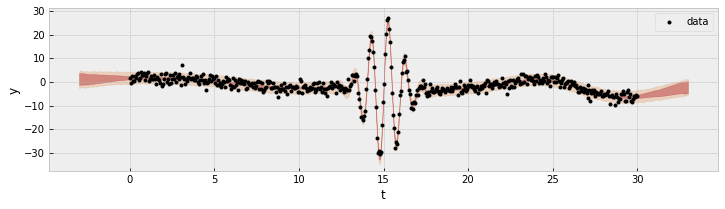

In [171]:
fig=plt.figure(figsize=(12,3 ))
ax=fig.add_subplot(111)

#mu,cov=mucovGPx(t,t,tau,sigma)
#ax.plot(t,mu)
#ax.plot(td, mean_muy,color="C1")
ax.fill_between(td, hpdi_muy[0], hpdi_muy[1], alpha=0.4, interpolate=True,color="C1")
#ax.plot(td, mean_muys,color="red")
ax.fill_between(td, hpdi_muys[0], hpdi_muys[1], alpha=0.2, interpolate=True,color="C4")
ax.plot(t,d,".",color="black",label="data")
#for i in list(map(int,np.random.random(20)*len(td))):
#    plt.plot(td,marr[i,:],lw=0.5,alpha=0.3,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp6.pdf")